<a href="https://colab.research.google.com/github/Yuliana1453/Klasifikasi-Gambar/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Fruits-360](https://www.kaggle.com/datasets/moltean/fruits)
- **Nama:** Yuliana
- **Email:** yulianayuls24@gmail.com
- **ID Dicoding:** MC224D5X1784

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import os
import tensorflow as tf
from google.colab import files
from PIL import Image

In [2]:
# Libraries untuk split data
!pip install split-folders
import splitfolders

In [3]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [4]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Preparation

### Data Loading

In [7]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuliana1453","key":"922ded906b70e997e0d6db25055c4c48"}'}

In [8]:
# Unduh dan ekstrak dataset
!wget -q https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip
!unzip -q master.zip

# Pindahkan folder Meta ke tempat yang sesuai
!mkdir -p /content/fruits-360-meta
!mv Fruit-Images-Dataset-master/fruits-360_dataset/fruits-360/meta/Meta /content/fruits-360-meta/

mv: cannot stat 'Fruit-Images-Dataset-master/fruits-360_dataset/fruits-360/meta/Meta': No such file or directory


## Menggabungkan data train dan test pada dataset

In [19]:
base_path = "/content/Fruit-Images-Dataset-master"
train_path = os.path.join(base_path, "Training")
test_path = os.path.join(base_path, "Test")
combined_path = "/content/all_data"

os.makedirs(combined_path, exist_ok=True)

# Gabungkan semua gambar ke dalam satu folder per kelas di all_data
for category in os.listdir(train_path):
    src_train = os.path.join(train_path, category)
    src_test = os.path.join(test_path, category)
    dst = os.path.join(combined_path, category)
    os.makedirs(dst, exist_ok=True)

    # Salin dari Training
    for file in os.listdir(src_train):
        shutil.copy(os.path.join(src_train, file), os.path.join(dst, file))
    # Salin dari Test
    for file in os.listdir(src_test):
        shutil.copy(os.path.join(src_test, file), os.path.join(dst, file))

print("Data berhasil digabung.")


Data berhasil digabung.


## Split Menjadi Train, Validation, dan Test

In [20]:
import splitfolders

splitfolders.ratio(
    "/content/all_data",            # folder gabungan semua data
    output="/content/split_data",   # output folder
    seed=42,
    ratio=(.7, .2, .1),             # 70% train, 20% val, 10% test
    group_prefix=None
)

Copying files: 90375 files [00:15, 5832.27 files/s]


## ImageDataGenerator

In [21]:
train_dir = "/content/split_data/train"
val_dir = "/content/split_data/val"
test_dir = "/content/split_data/test"

# Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    shuffle=False   # jangan shuffle agar evaluasi akurat
)


Found 63220 images belonging to 131 classes.
Found 18032 images belonging to 131 classes.
Found 9123 images belonging to 131 classes.


# Modelling

##Membangun Model CNN

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')  # Sesuai jumlah kelas
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 131)            │        33,667 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,403,971 (12.99 MB)

 Trainable params: 3,403,971 (12.99 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStoppingByAccuracy(Callback):
    def __init__(self, threshold=0.98): #Awalnya 85%, Namun karena hanya 1 epoch, maka grafik accuracy dan loss tidak punya banyak data untuk diplot — hanya 1 titik data → jadinya grafik terlihat datar / tidak terbentuk garis.
        super(CustomEarlyStoppingByAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")

        if train_acc is not None and val_acc is not None:
            if train_acc >= self.threshold and val_acc >= self.threshold:
                print(f"\n✅ Both training and validation accuracy ≥ {self.threshold*100:.0f}% — stopping training.")
                self.model.stop_training = True


In [24]:
custom_stop = CustomEarlyStoppingByAccuracy(threshold=0.85)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    #callbacks=[custom_stop]
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1976/1976 ━━━━━━━━━━━━━━━━━━━━ 199s 99ms/step - accuracy: 0.5775 - loss: 1.6861 - val_accuracy: 0.9627 - val_loss: 0.1093
Epoch 2/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 198s 98ms/step - accuracy: 0.9425 - loss: 0.1773 - val_accuracy: 0.9879 - val_loss: 0.0330
Epoch 3/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 191s 96ms/step - accuracy: 0.9637 - loss: 0.1098 - val_accuracy: 0.9908 - val_loss: 0.0425
Epoch 4/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 191s 97ms/step - accuracy: 0.9701 - loss: 0.0918 - val_accuracy: 0.9948 - val_loss: 0.0187
Epoch 5/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 191s 97ms/step - accuracy: 0.9775 - loss: 0.0705 - val_accuracy: 0.9880 - val_loss: 0.0385
Epoch 6/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 192s 97ms/step - accuracy: 0.9779 - loss: 0.0692 - val_accuracy: 0.9917 - val_loss: 0.0248
Epoch 7/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 191s 97ms/step - accuracy: 0.9815 - loss: 0.0580 - val_accuracy: 0.9943 - val_loss: 0.0211
Epoch 8/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 202s 96ms/step - accuracy: 0.9831 - lo

## Evaluasi dan Visualisasi

In [25]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9926 - loss: 0.0156
Test Accuracy: 99.32%
Test Loss: 0.0136


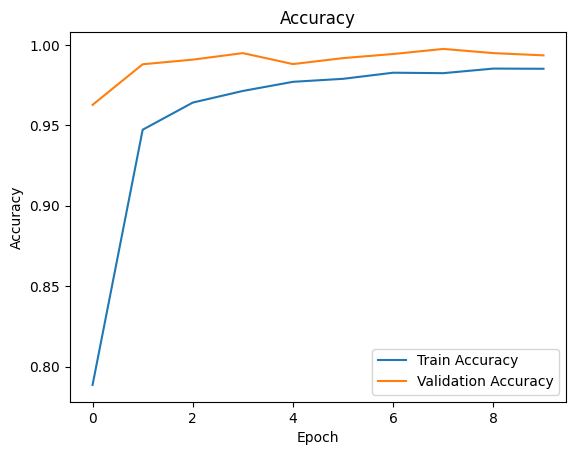

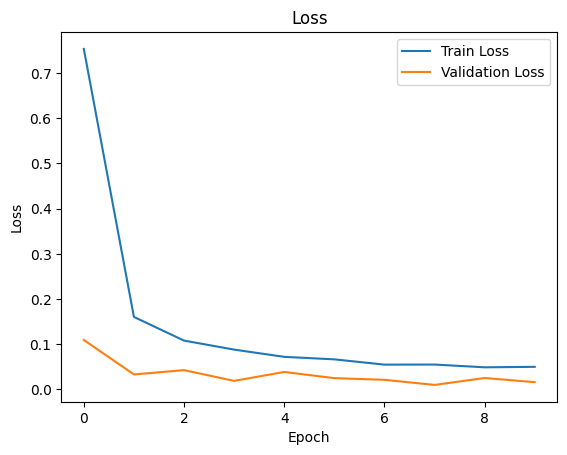

In [26]:
# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**🔍 Insight Model**

**📈 Accuracy**
- Train Accuracy meningkat drastis dari sekitar 80% ke atas 98% dalam 10 epoch.

- Validation Accuracy juga tinggi, mencapai sekitar 99% pada akhir epoch.

- Kurva training dan validation saling mendekati, artinya tidak terjadi overfitting yang berarti.

**📉 Loss**
- Train Loss turun signifikan dari sekitar 0.7 ke bawah 0.1, menunjukkan model belajar dengan baik.

- Validation Loss juga stabil dan rendah, bahkan lebih rendah dari training loss.

- Ini adalah tanda bahwa generalization model sangat baik, bahkan bisa jadi data validasi lebih mudah dipelajari oleh model daripada training data.

**✅ Kesimpulan**
- Model CNN berhasil belajar dengan sangat baik.

- Akurasi tinggi dan loss rendah di training dan validasi menunjukkan:

  - Dataset bersih dan seimbang

  - Arsitektur model sudah cukup optimal untuk tugas klasifikasi ini

  - Tidak terlihat gejala overfitting atau underfitting.

286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


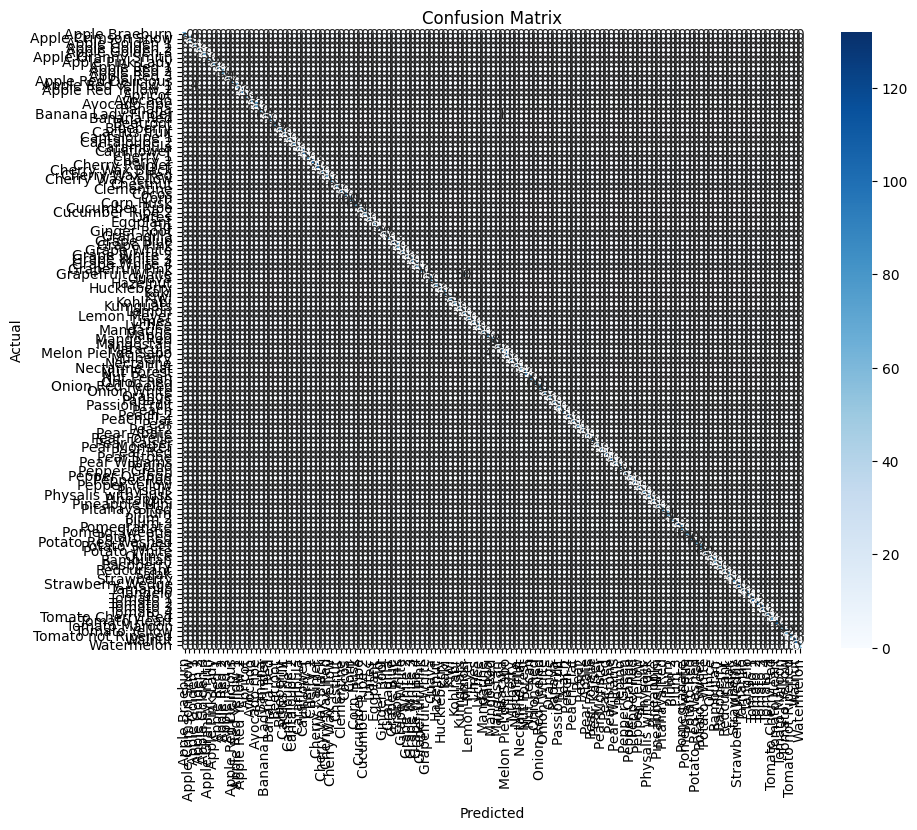

                     precision    recall  f1-score   support

     Apple Braeburn       1.00      1.00      1.00        66
 Apple Crimson Snow       1.00      1.00      1.00        60
     Apple Golden 1       0.94      1.00      0.97        64
     Apple Golden 2       1.00      1.00      1.00        66
     Apple Golden 3       1.00      1.00      1.00        65
 Apple Granny Smith       1.00      1.00      1.00        66
    Apple Pink Lady       1.00      1.00      1.00        62
        Apple Red 1       1.00      1.00      1.00        66
        Apple Red 2       1.00      1.00      1.00        66
        Apple Red 3       1.00      1.00      1.00        58
Apple Red Delicious       1.00      1.00      1.00        66
 Apple Red Yellow 1       1.00      0.94      0.97        66
 Apple Red Yellow 2       1.00      1.00      1.00        90
            Apricot       1.00      1.00      1.00        66
            Avocado       1.00      1.00      1.00        57
       Avocado ripe    

In [27]:
# Prediksi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

## Konversi Model

In [31]:
# --- [1] Pastikan folder struktur sudah dibuat ---
folders = [
    'submission/tfjs_model',
    'submission/tflite',
    'submission/saved_model/variables'  # folder variables wajib untuk format SavedModel
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

# --- [2] Export ke format SavedModel ---
model.export('submission/saved_model')

# --- [3] Convert ke format TFLite ---
converter = tf.lite.TFLiteConverter.from_saved_model('submission/saved_model')
tflite_model = converter.convert()

# Simpan model .tflite
with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# --- [4] Simpan Label ke label.txt ---
labels = sorted(os.listdir('/content/split_data/train'))

with open('submission/tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

# --- [5] Simpan model ke folder TFJS ---
!tensorflowjs_converter --input_format=tf_saved_model \
    submission/saved_model \
    submission/tfjs_model

print("✅ Semua format model berhasil diekspor!")


Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 131), dtype=tf.float32, name=None)
Captures:
  132280902562832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281129072208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281129072592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281129071632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281129073552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132281129073936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278740501136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278740502480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278740500752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132278740503248: TensorSpec(shape=(), dtype=tf.resource, name=None)
2025-

## Inference (Optional)

In [32]:
# Upload gambar
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="submission/tflite/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Resize sesuai kebutuhan model
img = Image.open(filename).convert("RGB").resize((100, 100))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

# Prediksi
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])[0]
predicted_class = np.argmax(output_data)

# Load label
with open("submission/tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f]

print(f"✅ Prediksi: {labels[predicted_class]} (Confidence: {output_data[predicted_class]:.2f})")


Saving 20220530094106_original.webp to 20220530094106_original (1).webp
✅ Prediksi: Tomato 2 (Confidence: 0.99)


In [33]:
!pip freeze > requirements.txt

!pip freeze > submission/requirements.txt

In [34]:
# Mengompres folder 'submission' jadi zip
!zip -r submission.zip /content/submission

# Baru download zip-nya
from google.colab import files
files.download("submission.zip")

  adding: content/submission/ (stored 0%)
  adding: content/submission/tflite/ (stored 0%)
  adding: content/submission/tflite/model.tflite (deflated 7%)
  adding: content/submission/tflite/label.txt (deflated 54%)
  adding: content/submission/requirements.txt (deflated 57%)
  adding: content/submission/tfjs_model/ (stored 0%)
  adding: content/submission/tfjs_model/model.json (deflated 88%)
  adding: content/submission/tfjs_model/group1-shard3of4.bin (deflated 6%)
  adding: content/submission/tfjs_model/group1-shard4of4.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard1of4.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard2of4.bin (deflated 6%)
  adding: content/submission/saved_model/ (stored 0%)
  adding: content/submission/saved_model/variables/ (stored 0%)
  adding: content/submission/saved_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/submission/saved_model/variables/variables.index (deflated 63%)
  adding: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>